# Tutorial 1 - Generation of impedance data

Now that how to define the input information is clear, we can generate some
data using the `generate_data.py` module.\
First of all, let's add the parent folder path to import the functions that
we need.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent)) 

## Single element case
### Resistor
If we take a single element, for example `R1`, that has an associated parameter
$R = 100\,\Omega$,

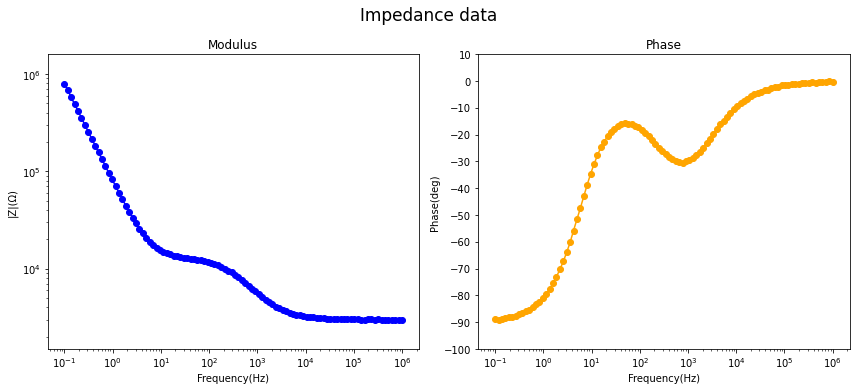

In [2]:
from generate_data import generate_constant_elements_array_data

circuit_string = '(R1)'
parameters = ([100])
constant_elements = generate_constant_elements_array_data(parameters)

where the constant elements conditions are not relevant in the generation
module (thus they are all set to 1 from now on), the generated impedance
function is

In [3]:
from generate_impedance import generate_impedance_function

impedance_function, parameters, _ = generate_impedance_function(
    circuit_string, parameters, constant_elements)

Here the last element given by the generate_impedance_function() is not used.
It regards a feature present only in the analysis module.\
We can set 100 frequency points in the range between $0.1\,Hz$ and $100\,kHz$

In [4]:
import numpy as np

log_frequency = np.linspace(-1, 5, 100)
frequency = 10.**log_frequency

and we can simulate some random noise

In [5]:

from generate_data import simulate_noise

signal = impedance_function(parameters, frequency)
impedance = simulate_noise(signal)


Now, if we plot the impedance modulus and phase, we should get a constant
impedance with modulus $Z = 100\,\Omega$ and zero phase.

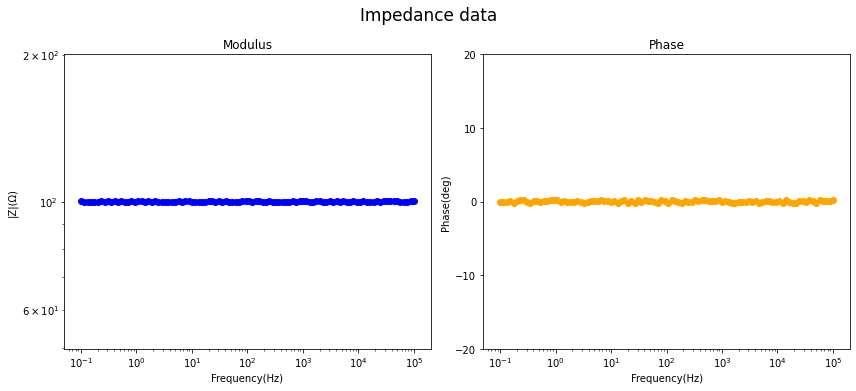

In [ ]:
from plot_and_save import plot_data

plot_data(frequency, impedance)

### Capacitor
Another simple example is the capacitor case. We can take a capacitor `C1`
with a capacitance $C = 1\,\mu F$.

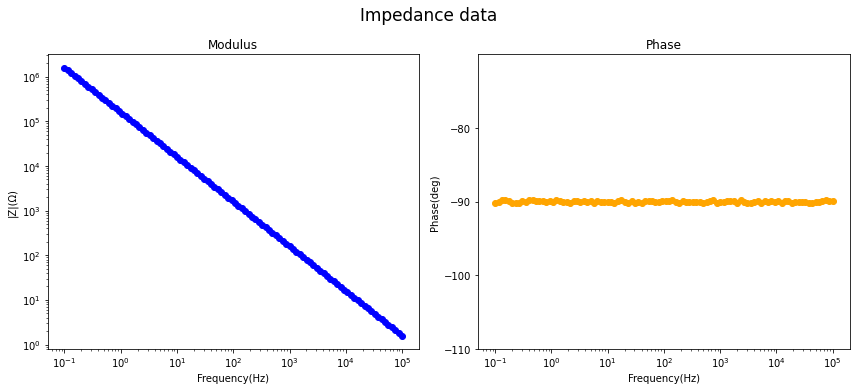

In [7]:
circuit_string = '(C1)'
parameters = ([1e-6])
constant_elements = generate_constant_elements_array_data(parameters)

impedance_function, parameters, _ = generate_impedance_function(
    circuit_string, parameters, constant_elements)

signal = impedance_function(parameters, frequency)
impedance = simulate_noise(signal)

plot_data(frequency, impedance)

## Two-element circuit
### RC series 
One of the most basic circuit that however manages to describe real-life data
is the RC series circuit. As explained before, the "in series" junction is
done delimitatting the elements with round brakets.

In [8]:
circuit_string = '(R1C2)'

This string corresponds to the circuit
<p align="center">
    <img src="Images_tutorial/RC_series.png" alt="image" width="500"/>
</p>

Now, if we set $R = 1\,k\Omega$ and $C = 1\,\mu F$

In [9]:
parameters = ([1e3, 1e-6])
constant_elements = generate_constant_elements_array_data(parameters)

The resultat plot is

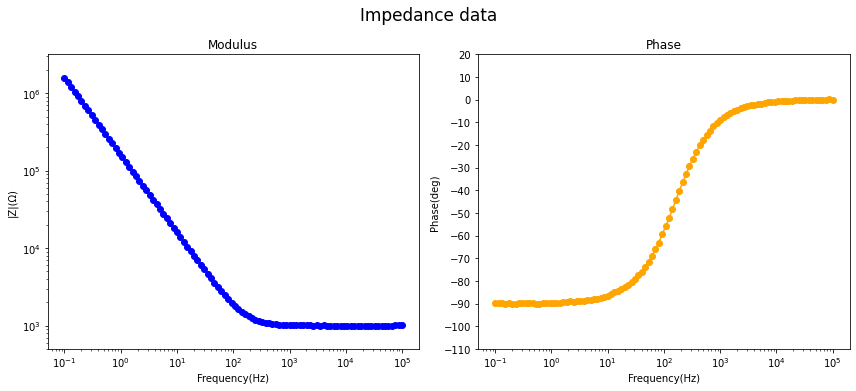

In [10]:
impedance_function, parameters, _ = generate_impedance_function(
    circuit_string, parameters, constant_elements)

signal = impedance_function(parameters, frequency)
impedance = simulate_noise(signal)

plot_data(frequency, impedance)

### RC parallel 
The counterpart of the last circuit is the RC in parallel (below, a scheme).
Now the string must be with the square brackets. If we use the same values
<p align="center">
    <img src="Images_tutorial/RC_parallel.png" alt="image" width="500"/>
</p>

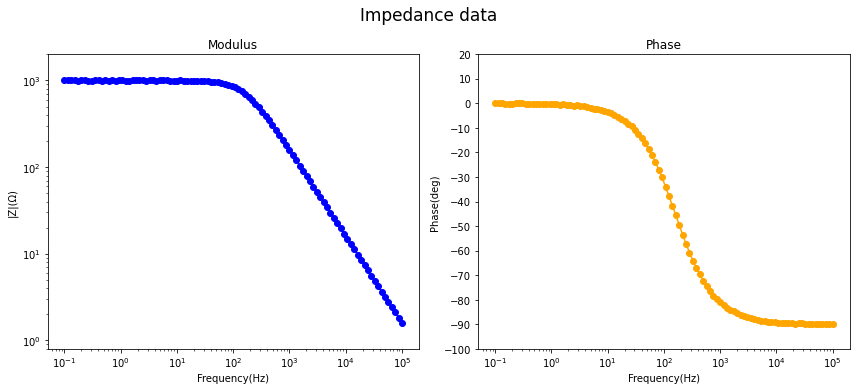

In [11]:
circuit_string = '[R1C2]'

parameters = ([1e3, 1e-6])
constant_elements = generate_constant_elements_array_data(parameters)

impedance_function, parameters, _ = generate_impedance_function(
    circuit_string, parameters, constant_elements)

signal = impedance_function(parameters, frequency)
impedance = simulate_noise(signal)

plot_data(frequency, impedance)

### Many elements circuit
To make more complex circuits the only thing to do is write the correct string
and add parameters. If there are multiple pairs of barckets (which are not in
conflict with each other), the algorithm will work like this:
- the elements inside the inner pair of brakets will be analyzed first (the
most nested one)
- an equivalent impedance element $Zi$ with its impedance function and
parameters will replace the analyzed elements (and the related brackets)
- the new most nested pair of brackets will be analyzed as explained before, 
and so on and so fourth until there is only one element $Zi$. This is actually
how the program ran behind the scenes so far.\
Thus, if we take the circuit string `(R1C2[R3Q4])` (that correspond to the
circuit below), during the analysis the string will be transformed as\
`(R1C2[R3Q4])` -> `(R1C2Z1)` -> `Z2`\
Since no bracket is detected, the program knows that the analysis is done.\
Note: the number after the $Z$ corresponds only to "the cycle of analysis"
that created that $Z$ element.
<p align="center">
    <img src="Images_tutorial/(R1C2[R3Q4]).png" alt="image" width="460"/>
</p>

In [12]:
circuit_string = '(R1C2[R3Q4])'

For the value of this circuit let's set for the resistors $R1 = 3\,k\Omega$
and $R3 = 10\,k\Omega$ and for the capacitors $C2 = 2\,\mu F$. Regarding the
constant phase elements, we could settle for a $Q = 0.2 \cdot 10^{-6}$ and
an ideality factor $n = 0.82$.

In [13]:
parameters = ([3000, 2e-6, 10000, ([0.2e-6, 0.82])])
constant_elements = generate_constant_elements_array_data(parameters)

Then, the generated impedance will be

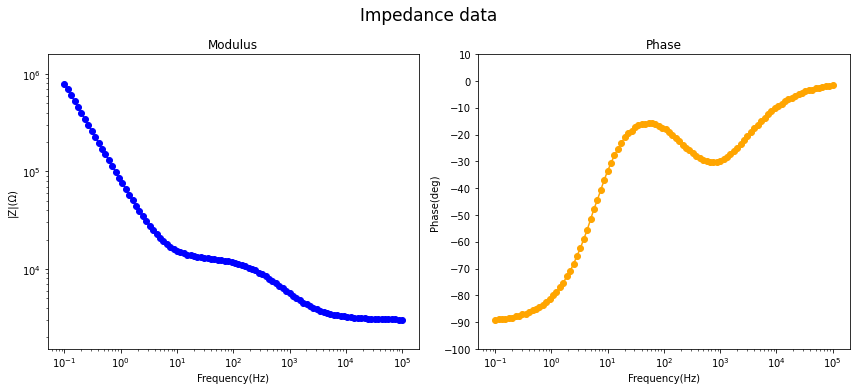

In [14]:
impedance_function, parameters, _ = generate_impedance_function(
    circuit_string, parameters, constant_elements)

signal = impedance_function(parameters, frequency)
impedance = simulate_noise(signal)

plot_data(frequency, impedance)

## Saving the data
After all of this data generation, we may want to save all of the generated
data. The considered method is to write the frequency array and the complex
impedance array inside of a `.txt` file, the two columns are separated  by a
`;`. It is done with

In [15]:
from generate_data import save_data

fine_name = 'Tutorial_generated_data.txt'
save_data(fine_name, frequency, impedance)